<a href="https://colab.research.google.com/github/dibsondivya/ai-health-event/blob/main/training/Bing_Xuan_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation of Required Libraries

In [2]:
#### Installation of H2O and nltk (Uncomment below 4 lines)
!apt-get install default-jre
!java -version
!pip install h2o
!pip install nltk
!pip install stanza

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.0 MB 39 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.2-py2.py3-none-any.whl size=177070945 sha256=42a799deb2e3d90e26a16ee5924b0ede2be04d605f627ff053986b3376a62edb
  Stored in directory: /root/.cache/pip/wheels/a5/2b/ae/534595df09001e1573b1046be62a3f0

# Import Data and Undergo Preliminary Processing

We process both train and test datasets into H2O frames, before tokenising them and training them with a word2vec model via transfer learning

In [3]:
import nltk
nltk.download('punkt')

## Download Stop Words
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
### Import Libraries
import pandas as pd

# Import the dataset into H2O:
twitter =pd.read_csv('/content/drive/MyDrive/AI Project/train_textcleaned.csv')
test =pd.read_csv('/content/drive/MyDrive/AI Project/test_textcleaned.csv')

In [5]:
import h2o
h2o.init()

## Convert all 3 sets to H2o Frames
h2o_train_df = h2o.H2OFrame(twitter)
h2o_test_df = h2o.H2OFrame(test)

## Convert label column to factor type
h2o_train_df['label'] = h2o_train_df['label'].asfactor()
h2o_test_df['label'] = h2o_test_df['label'].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpox273hi0
  JVM stdout: /tmp/tmpox273hi0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpox273hi0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_7wjwtq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
from h2o.estimators import H2OWord2vecEstimator, H2OGradientBoostingEstimator

# Make the 'tokenize' function:
def tokenize(sentences, stop_word = stop_words):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(stop_words)),:]
    return tokenized_words

# Make the `predict` function:
def predict(testset,w2v, gbm):
    words = tokenize(h2o.H2OFrame(testset).ascharacter())
    testset_vec = w2v.transform(words, aggregate_method="AVERAGE")
    print(gbm.predict(test_data=testset_vec))

# Break job titles into a sequence of words:
words = tokenize(h2o_train_df["tweet"])
test_words = tokenize(h2o_test_df["tweet"])

## Import pretrained model
#w2v_frame = h2o.import_file("/content/drive/MyDrive/AI Project/glove.6B.100d.txt")
w2v_frame = h2o.import_file("/content/drive/MyDrive/AI Project/glove.twitter.27B.100d.txt")


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Build Word2Vec Models

In [7]:
## Build First word2vec model:
w2v_model = H2OWord2vecEstimator(pre_trained = w2v_frame
                                 ,epochs=5
                                 #,sent_sample_rate=0.005
                                 ,init_learning_rate=0.035
                                 )
w2v_model.train(training_frame=words)

word2vec Model Build progress: |█████████████████████████████████████████████████| (done) 100%
Model Details
H2OWord2vecEstimator :  Word2Vec
Model Key:  Word2Vec_model_python_1655653774707_1

No model summary for this model


In [8]:
# Calculate a vector for each tweet:
twitter_tweet_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
twitter_tweet_test_vecs = w2v_model.transform(test_words, aggregate_method = "AVERAGE")

# Prepare training & validation data (keep only tweets made of known words):
valid_tweet_tweets = ~ twitter_tweet_vecs["C1"].isna()
data = h2o_train_df[valid_tweet_tweets,:].cbind(twitter_tweet_vecs[valid_tweet_tweets,:])
data_split = data.split_frame(ratios=[0.8])

# Prepare test data):
#valid_test_tweet_tweets = ~ twitter_tweet_test_vecs["C1"].isna()
testdata = h2o_test_df.cbind(twitter_tweet_test_vecs)

# Test Word2Vec Model on Gradient Boosting Machine Classification

In [9]:
# Build a basic GBM model:
gbm_model = H2OGradientBoostingEstimator(seed = 1)
gbm_model.train(x = twitter_tweet_vecs.names,
                y="label",
                training_frame = data_split[0],
                validation_frame = data_split[1])


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1655653774707_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,200.0,58803.0,5.0,5.0,5.0,8.0,29.0,18.765




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.06723048209047862
RMSE: 0.2592884148790274
LogLoss: 0.24962646526264384
Mean Per-Class Error: 0.1336978573646756
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,266.0,48.0,0.0,0.0,0.152866,48 / 314
1,1.0,897.0,1.0,2.0,0.004440,4 / 901
2,1.0,29.0,99.0,0.0,0.232558,30 / 129
3,0.0,9.0,1.0,59.0,0.144928,10 / 69
4,268.0,983.0,101.0,61.0,0.065110,"92 / 1,413"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.934890
1,2,0.985846
2,3,0.996461
3,4,1.000000



ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.28588946507810387
RMSE: 0.534686324005116
LogLoss: 0.8838515212075169
Mean Per-Class Error: 0.6344429652915892
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,21.0,62.0,1.0,0.0,0.750000,63 / 84
1,14.0,201.0,1.0,2.0,0.077982,17 / 218
2,11.0,27.0,6.0,0.0,0.863636,38 / 44
3,2.0,9.0,0.0,2.0,0.846154,11 / 13
4,48.0,299.0,8.0,4.0,0.359331,129 / 359



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.640668
1,2,0.877437
2,3,0.980501
3,4,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2022-06-19 15:51:01,0.183 sec,0.0,0.750000,1.386294,0.551309,NaN,NaN,0.750000,1.386294,0.593315,NaN,NaN
1,,2022-06-19 15:51:02,1.621 sec,1.0,0.711027,1.244643,0.244869,NaN,NaN,0.721915,1.284266,0.398329,NaN,NaN
2,,2022-06-19 15:51:03,2.242 sec,2.0,0.675832,1.134310,0.221515,NaN,NaN,0.698052,1.209373,0.392758,NaN,NaN
3,,2022-06-19 15:51:03,2.746 sec,3.0,0.643268,1.042215,0.205945,NaN,NaN,0.677087,1.150160,0.378830,NaN,NaN
4,,2022-06-19 15:51:04,3.284 sec,4.0,0.614341,0.967017,0.196745,NaN,NaN,0.659022,1.103179,0.384401,NaN,NaN
5,,2022-06-19 15:51:04,3.647 sec,5.0,0.587283,0.900934,0.179759,NaN,NaN,0.643191,1.064105,0.387187,NaN,NaN
6,,2022-06-19 15:51:05,4.023 sec,6.0,0.562884,0.844162,0.173390,NaN,NaN,0.629853,1.033027,0.384401,NaN,NaN
7,,2022-06-19 15:51:09,8.156 sec,18.0,0.396054,0.496344,0.116065,NaN,NaN,0.557775,0.882366,0.367688,NaN,NaN
8,,2022-06-19 15:51:13,12.277 sec,41.0,0.280744,0.287767,0.067941,NaN,NaN,0.538073,0.874630,0.350975,NaN,NaN
9,,2022-06-19 15:51:15,14.127 sec,50.0,0.259288,0.249626,0.065110,NaN,NaN,0.534686,0.883852,0.359331,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C24,185.828232,1.000000,0.078406
1,C93,94.883461,0.510598,0.040034
2,C78,59.213867,0.318648,0.024984
3,C65,54.822742,0.295018,0.023131
4,C8,49.659878,0.267235,0.020953
5,C49,46.509621,0.250283,0.019624
6,C28,45.760319,0.246251,0.019308
7,C80,43.254101,0.232764,0.018250
8,C39,43.023090,0.231521,0.018153
9,C27,42.124638,0.226686,0.017774



See the whole table with table.as_data_frame()


In [10]:
# Eval performance:
perf = gbm_model.model_performance(testdata)
perf


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.38095933453895087
RMSE: 0.6172190328715981
LogLoss: 1.2843099315442392
Mean Per-Class Error: 0.6905725553904739
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,75.0,313.0,3.0,1.0,0.808673,317 / 392
1,39.0,693.0,4.0,1.0,0.059701,44 / 737
2,14.0,125.0,7.0,0.0,0.952055,139 / 146
3,6.0,73.0,2.0,5.0,0.941860,81 / 86
4,134.0,1204.0,16.0,7.0,0.426892,"581 / 1,361"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.573108
1,2,0.839824
2,3,0.941954
3,4,1.000000


# Test Word2Vec Model on AutoML Classification

In [24]:
from h2o.automl import H2OAutoML
## Initialise automl
aml = H2OAutoML(max_models = 50, seed = 8888, 
                verbosity="info", nfolds=0, 
                include_algos = ["DeepLearning"],
                max_runtime_secs = 600,
                balance_classes=True, max_after_balance_size=0.3)

## Train AutoML Model
aml.train(x = twitter_tweet_vecs.names,y="label",
          training_frame = data_split[0],
          validation_frame = data_split[1])

AutoML progress: |
15:56:28.16: Project: AutoML_1_20220619_155627
15:56:28.17: Cross-validation disabled by user: no fold column nor nfolds > 1.
15:56:28.17: Setting stopping tolerance adaptively based on the training frame: 0.026602896148920738
15:56:28.18: Build control seed: 8888
15:56:28.18: training frame: Frame key: AutoML_1_20220619_155627_training_py_384_sid_acbd    cols: 103    rows: 1413  chunks: 1    size: 1285897  checksum: 5888223289551296452
15:56:28.19: validation frame: Frame key: py_385_sid_acbd    cols: 103    rows: 359  chunks: 1    size: 332352  checksum: -5441299245453075038
15:56:28.19: leaderboard frame: Frame key: py_385_sid_acbd    cols: 103    rows: 359  chunks: 1    size: 332352  checksum: -5441299245453075038
15:56:28.19: blending frame: NULL
15:56:28.19: response column: label
15:56:28.19: fold column: null
15:56:28.19: weights column: null
15:56:28.44: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w)

,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,100,Input,20.0,,,,,,,,,
1,,2,50,RectifierDropout,40.0,0.0,0.0,0.000202,0.000133,0.0,0.000187,0.107548,0.047717,0.14065
2,,3,4,Softmax,,0.0,0.0,0.000311,0.00024,0.0,-0.100387,0.756747,-0.641523,0.297874




ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.12482548627175635
RMSE: 0.3533065047119234
LogLoss: 0.41795824914455293
Mean Per-Class Error: 0.14465473470423965
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,88.0,11.0,0.0,1.0,0.120000,12 / 100
1,0.0,100.0,0.0,1.0,0.009901,1 / 101
2,4.0,31.0,72.0,1.0,0.333333,36 / 108
3,0.0,11.0,1.0,92.0,0.115385,12 / 104
4,92.0,153.0,73.0,95.0,0.147700,61 / 413



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.852300
1,2,0.937046
2,3,0.978208
3,4,1.000000



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.34092623140209893
RMSE: 0.5838888861779259
LogLoss: 1.3994805695746801
Mean Per-Class Error: 0.47359635777066966
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,33.0,38.0,10.0,3.0,0.607143,51 / 84
1,25.0,155.0,17.0,21.0,0.288991,63 / 218
2,10.0,15.0,17.0,2.0,0.613636,27 / 44
3,1.0,3.0,1.0,8.0,0.384615,5 / 13
4,69.0,211.0,45.0,34.0,0.406685,146 / 359



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.593315
1,2,0.810585
2,3,0.938719
3,4,1.000000



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_r2,validation_classification_error,validation_auc,validation_pr_auc
0,,2022-06-19 15:57:46,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-06-19 15:57:46,1 min 17.439 sec,18034 obs/sec,10.0,1,4130.0,0.721378,2.290770,0.579440,0.600484,NaN,NaN,0.759031,2.925945,-0.152551,0.654596,NaN,NaN
2,,2022-06-19 15:57:51,1 min 22.450 sec,26074 obs/sec,330.0,33,136290.0,0.419093,0.574668,0.858054,0.215496,NaN,NaN,0.590627,1.405965,0.302142,0.417827,NaN,NaN
3,,2022-06-19 15:57:56,1 min 27.457 sec,28691 obs/sec,710.0,71,293230.0,0.353307,0.417958,0.899120,0.147700,NaN,NaN,0.583889,1.399481,0.317973,0.406685,NaN,NaN
4,,2022-06-19 15:58:01,1 min 32.466 sec,30393 obs/sec,1120.0,112,462560.0,0.323410,0.354862,0.915470,0.121065,NaN,NaN,0.588567,1.502564,0.307000,0.403900,NaN,NaN
5,,2022-06-19 15:58:06,1 min 37.516 sec,31803 obs/sec,1560.0,156,644280.0,0.310191,0.324158,0.922239,0.108959,NaN,NaN,0.597832,1.656194,0.285011,0.403900,NaN,NaN
6,,2022-06-19 15:58:11,1 min 42.524 sec,32379 obs/sec,1980.0,198,817740.0,0.302584,0.307328,0.926006,0.106538,NaN,NaN,0.600095,1.775731,0.279587,0.406685,NaN,NaN
7,,2022-06-19 15:58:16,1 min 47.559 sec,33149 obs/sec,2430.0,243,1003590.0,0.296368,0.297322,0.929015,0.099274,NaN,NaN,0.605410,1.913228,0.266770,0.403900,NaN,NaN
8,,2022-06-19 15:58:16,1 min 47.584 sec,33138 obs/sec,2430.0,243,1003590.0,0.353307,0.417958,0.899120,0.147700,NaN,NaN,0.583889,1.399481,0.317973,0.406685,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C49,1.000000,1.000000,0.012717
1,C29,0.980375,0.980375,0.012467
2,C85,0.973441,0.973441,0.012379
3,C53,0.946819,0.946819,0.012040
4,C42,0.940310,0.940310,0.011957
5,C41,0.932841,0.932841,0.011862
6,C24,0.931605,0.931605,0.011847
7,C77,0.929851,0.929851,0.011824
8,C52,0.916296,0.916296,0.011652
9,C25,0.908501,0.908501,0.011553



See the whole table with table.as_data_frame()


In [25]:
# Get leaderboard with all possible columns
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb

model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
DeepLearning_grid_1_AutoML_1_20220619_155627_model_4,0.473596,1.39948,0.583889,0.340926,30446,0.055074,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_16,0.51313,1.51316,0.578328,0.334463,26068,0.053239,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_11,0.525032,1.63101,0.613856,0.376819,30635,0.018069,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_17,0.563492,1.64536,0.628863,0.395469,30634,0.018687,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_7,0.564418,1.75906,0.623248,0.388438,30677,0.018724,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_8,0.575675,1.67672,0.599456,0.359348,32659,0.039238,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_10,0.584631,1.87464,0.609777,0.371828,25450,0.017421,DeepLearning
DeepLearning_grid_2_AutoML_1_20220619_155627_model_4,0.587605,0.958667,0.555312,0.308371,31004,0.033306,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_2,0.590329,2.59485,0.63229,0.399791,25871,0.032772,DeepLearning
DeepLearning_grid_1_AutoML_1_20220619_155627_model_3,0.606099,1.26798,0.594666,0.353628,25323,0.011773,DeepLearning


In [26]:
# Get the best model using the metric
best_dl_model = aml.leader

# View the parameters for the XGBoost model selected above
best_dl_model.params

{'activation': {'actual': 'RectifierWithDropout',
  'default': 'Rectifier',
  'input': 'RectifierWithDropout'},
 'adaptive_rate': {'actual': True, 'default': True, 'input': True},
 'auc_type': {'actual': 'AUTO', 'default': 'AUTO', 'input': 'AUTO'},
 'autoencoder': {'actual': False, 'default': False, 'input': False},
 'average_activation': {'actual': 0.0, 'default': 0.0, 'input': 0.0},
 'balance_classes': {'actual': True, 'default': False, 'input': True},
 'categorical_encoding': {'actual': 'OneHotInternal',
  'default': 'AUTO',
  'input': 'AUTO'},
 'checkpoint': {'actual': None, 'default': None, 'input': None},
 'class_sampling_factors': {'actual': None, 'default': None, 'input': None},
 'classification_stop': {'actual': 0.0, 'default': 0.0, 'input': 0.0},
 'col_major': {'actual': False, 'default': False, 'input': False},
 'diagnostics': {'actual': True, 'default': True, 'input': True},
 'distribution': {'actual': 'multinomial',
  'default': 'AUTO',
  'input': 'multinomial'},
 'elastic

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## DeepLearning_grid_1_AutoML_1_20220619_155627_model_4


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,76.0,280.0,24.0,12.0,0.806122,316 / 392
1,72.0,587.0,49.0,29.0,0.203528,150 / 737
2,18.0,105.0,20.0,3.0,0.863014,126 / 146
3,3.0,67.0,6.0,10.0,0.883721,76 / 86
4,169.0,1039.0,99.0,54.0,0.490816,"668 / 1,361"


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

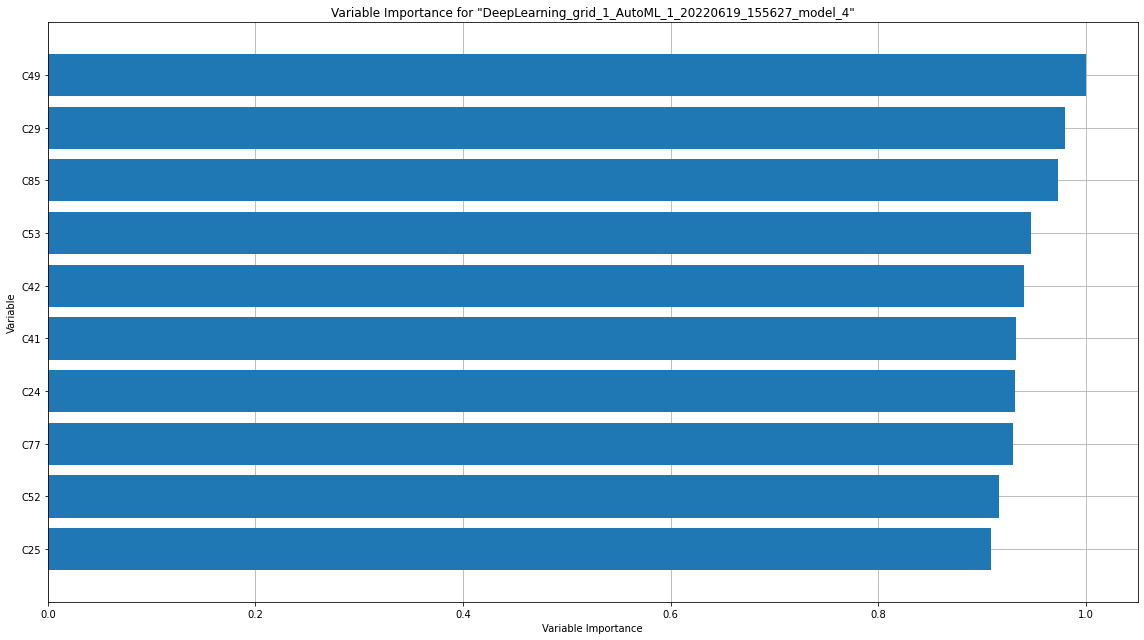

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

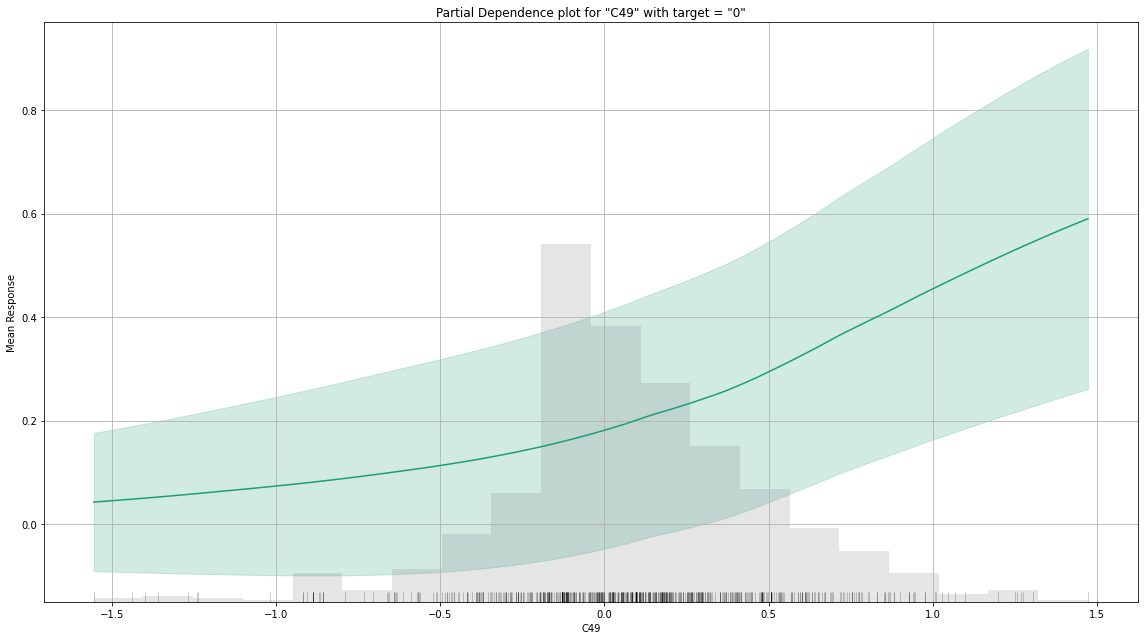

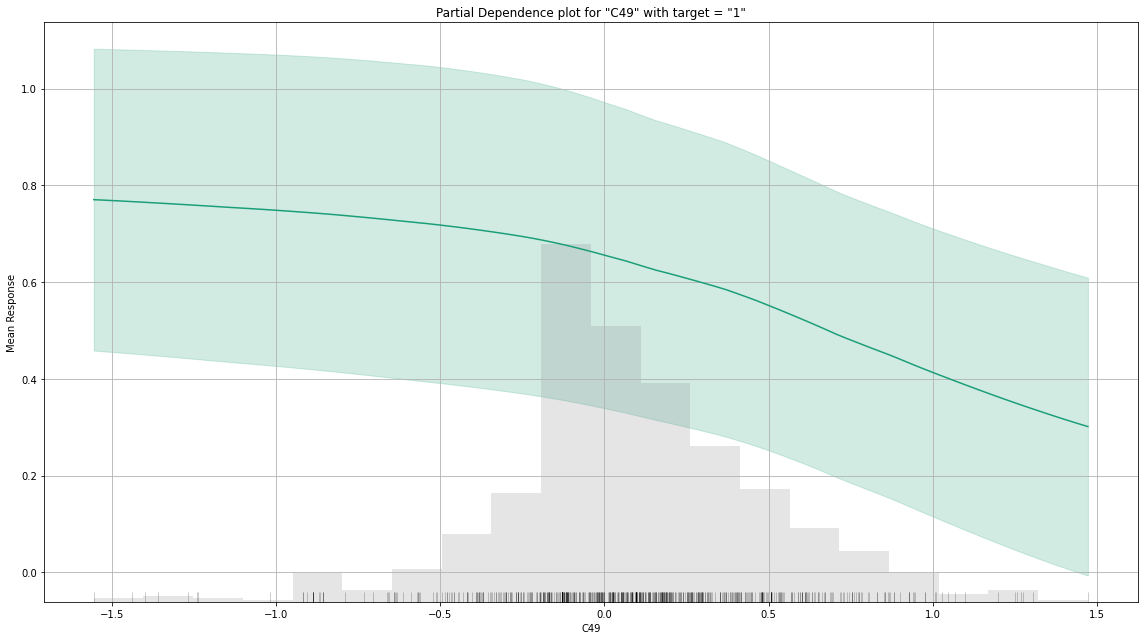

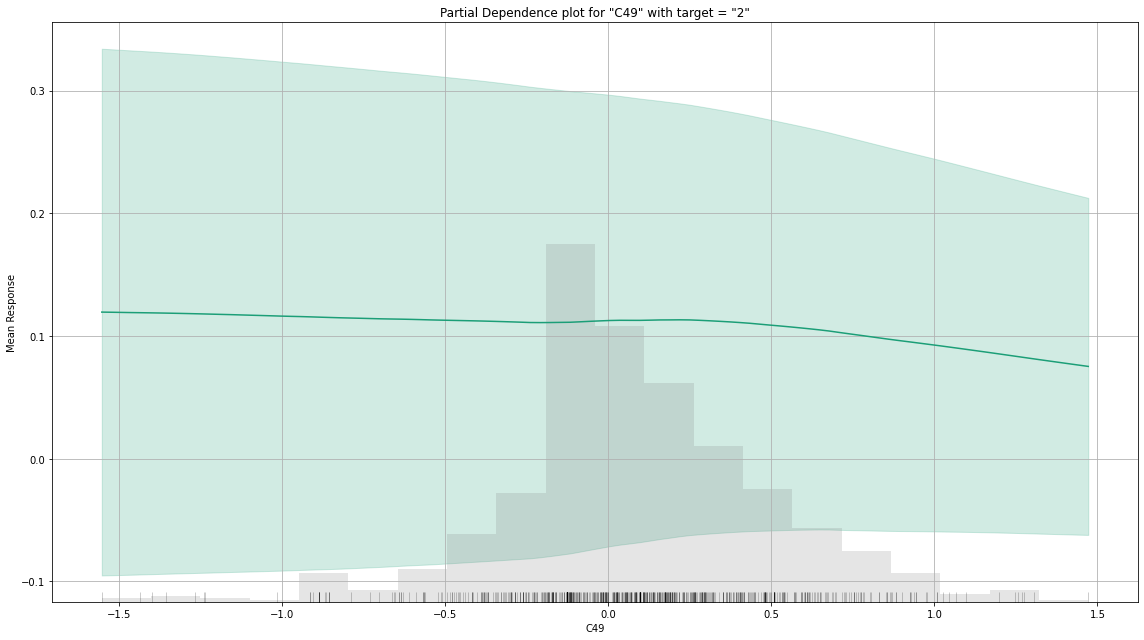

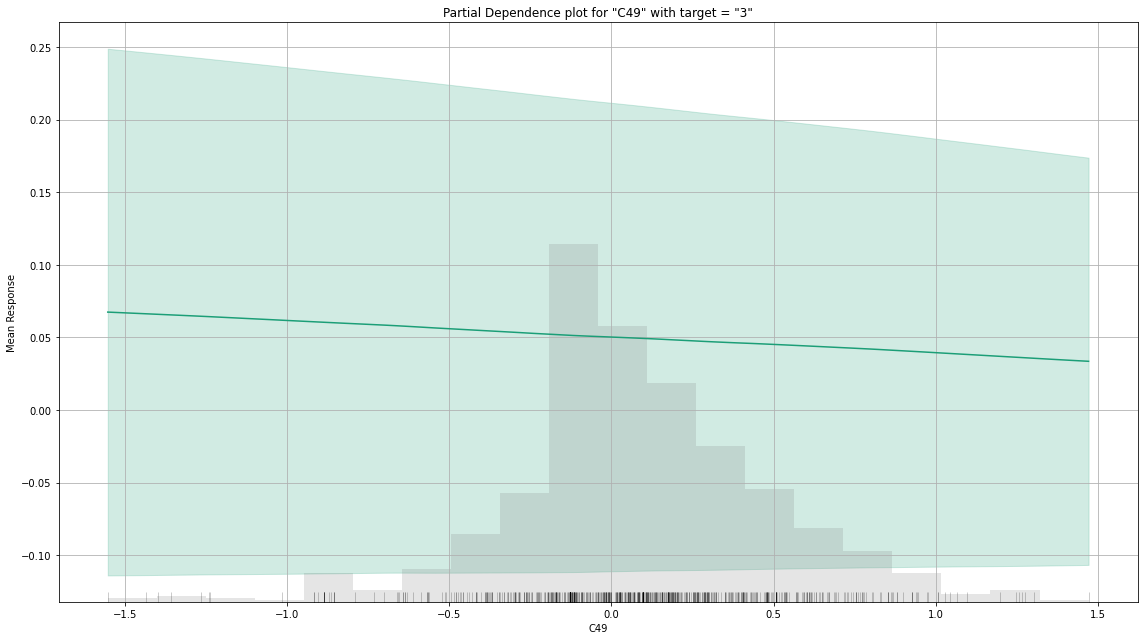

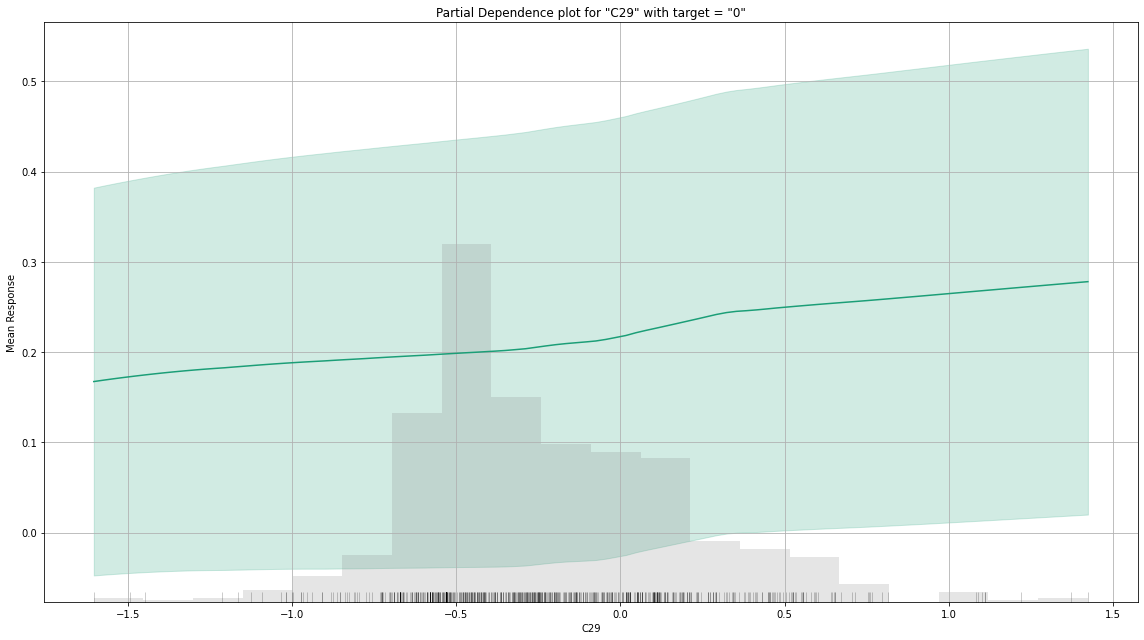

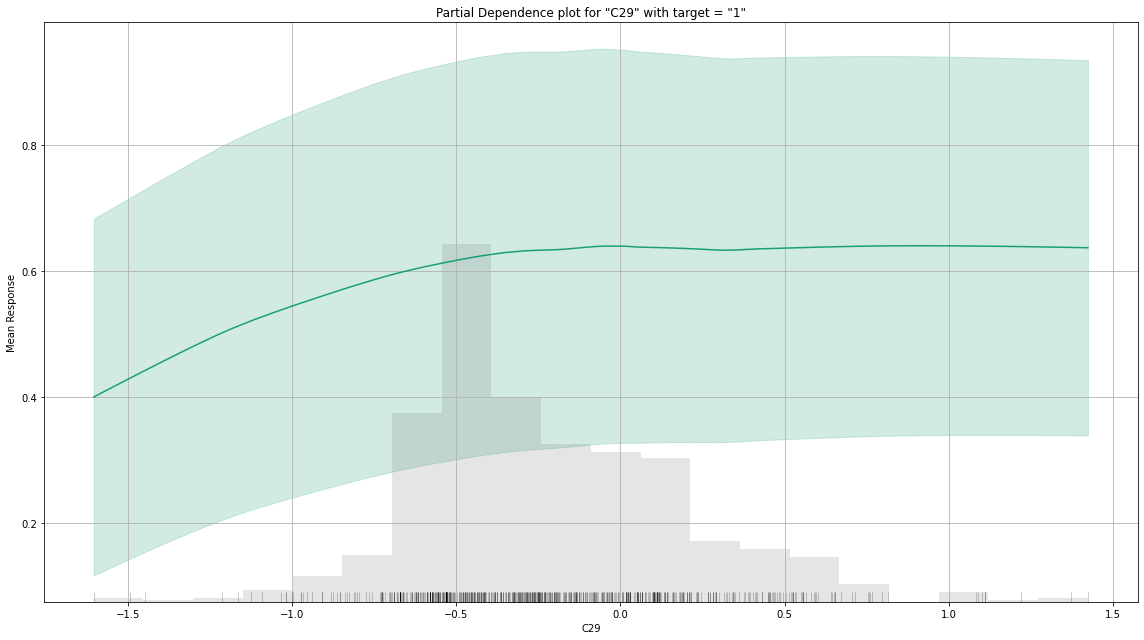

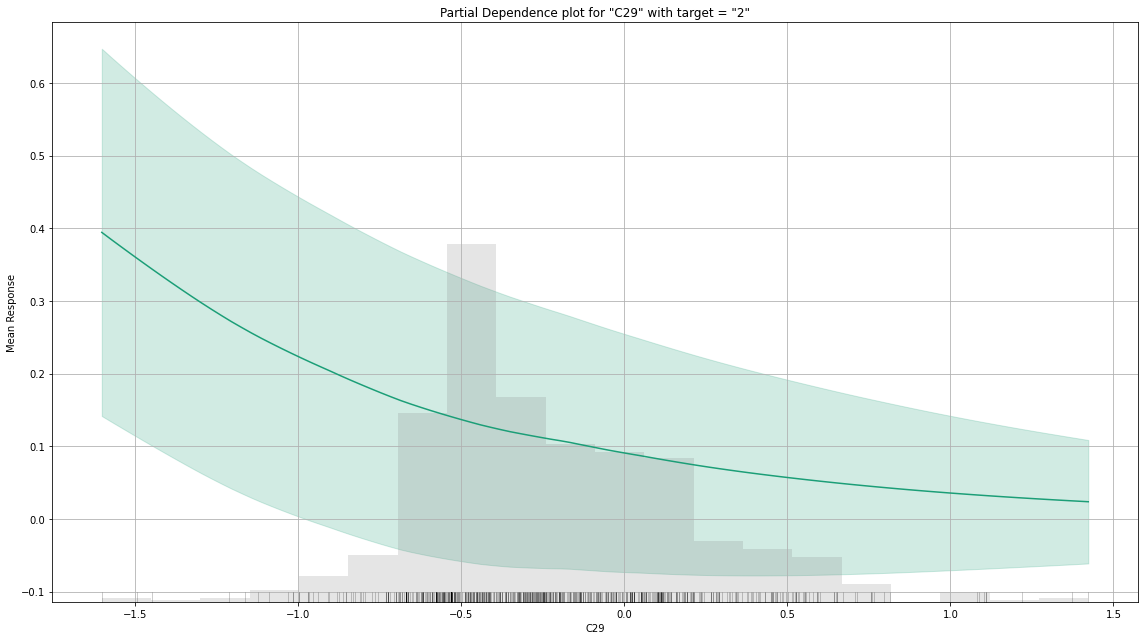

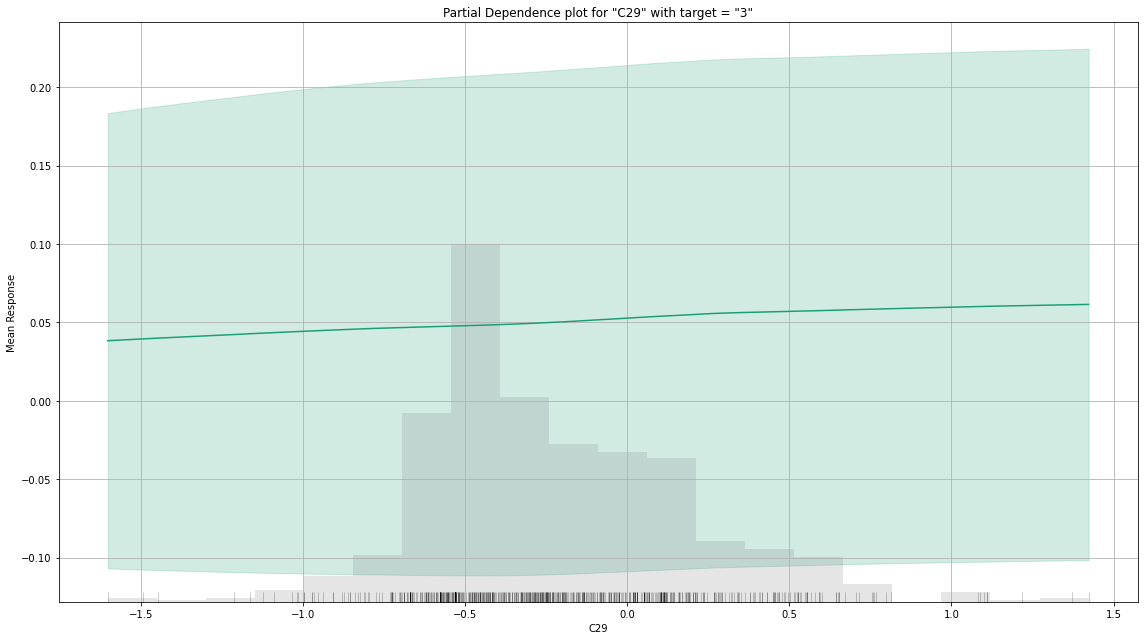

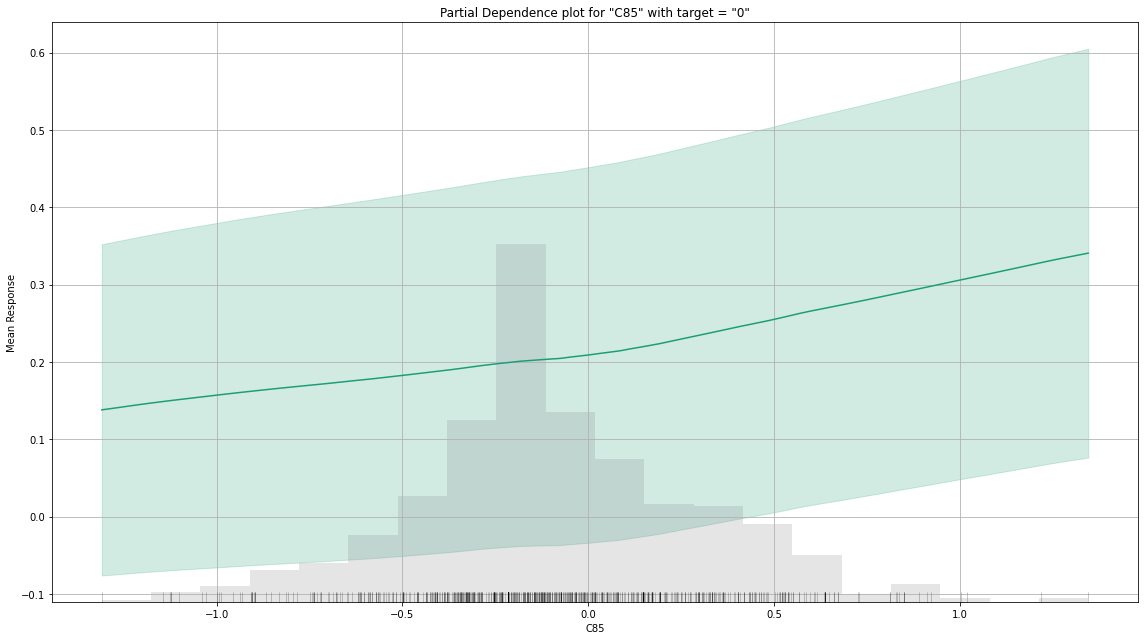

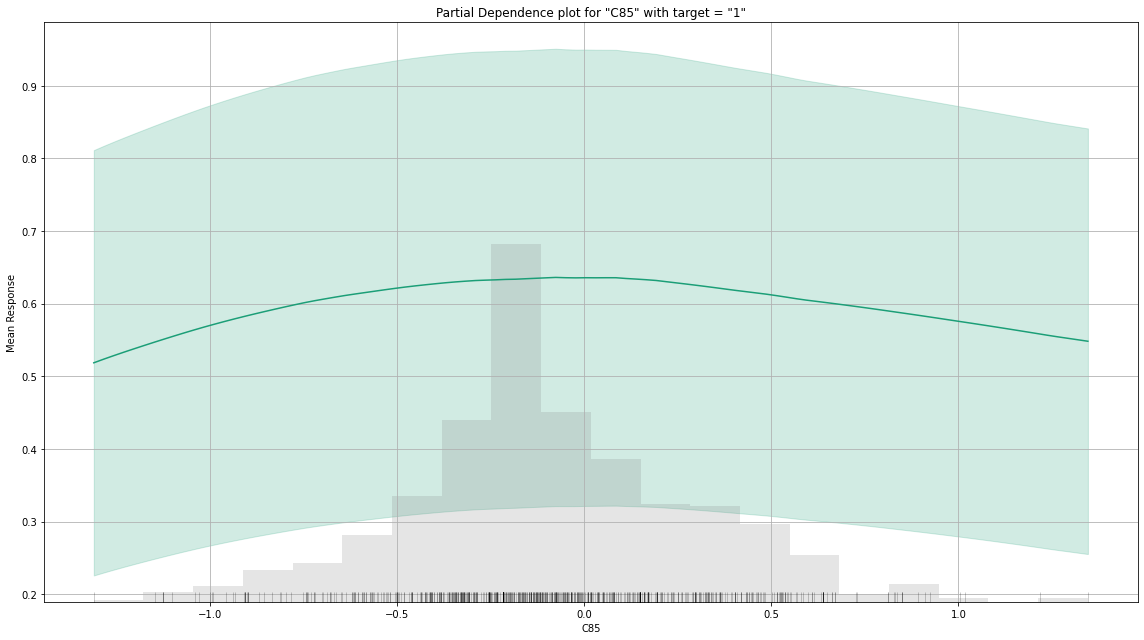

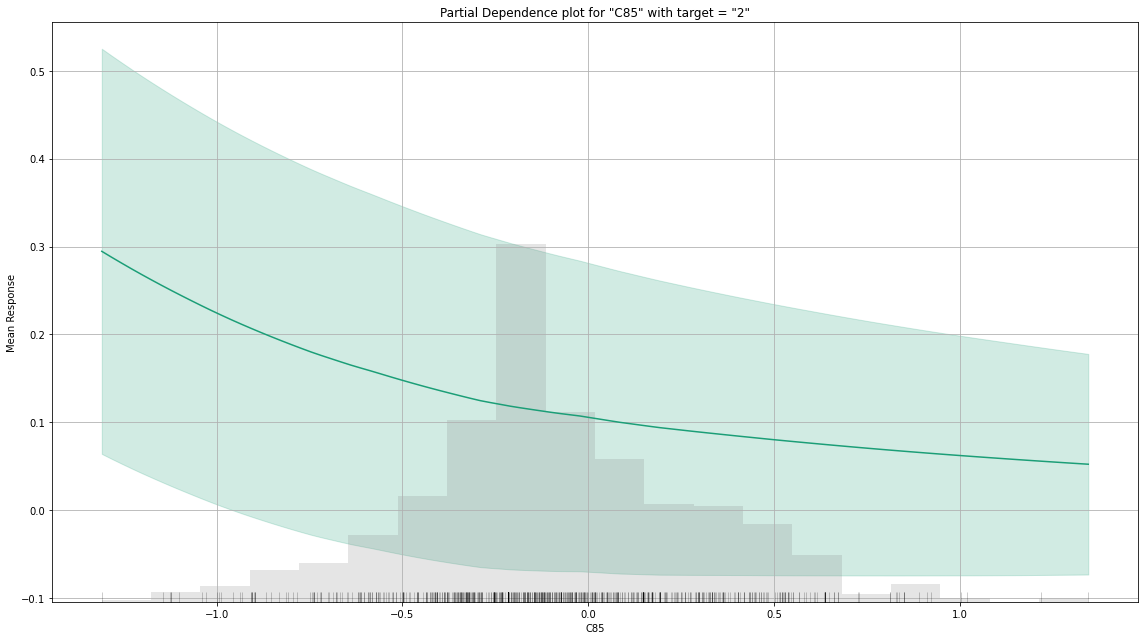

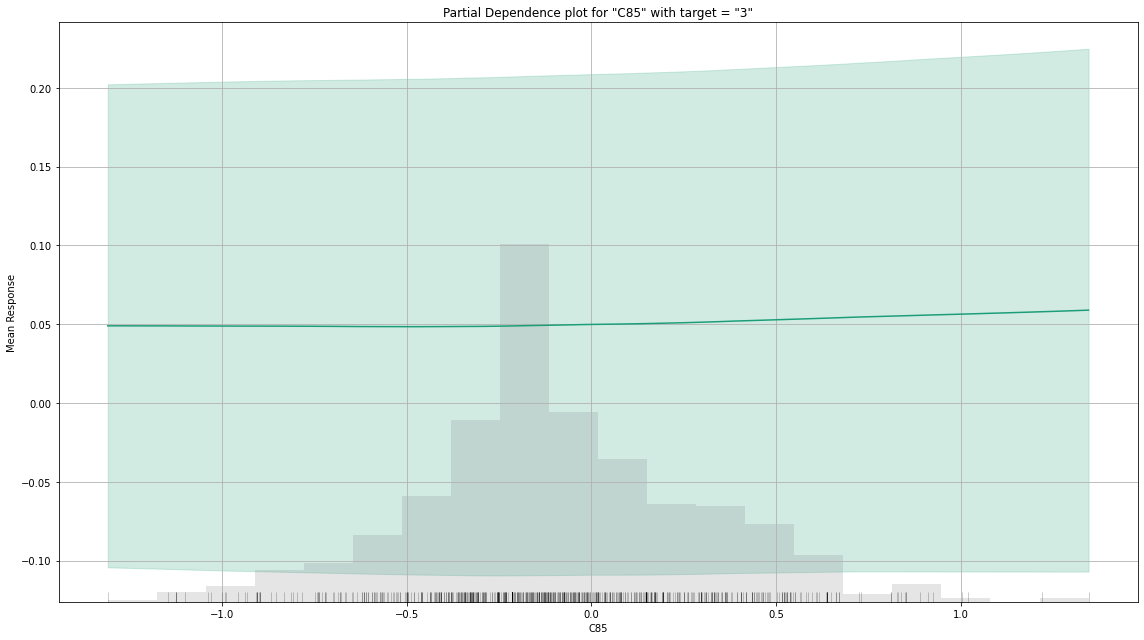

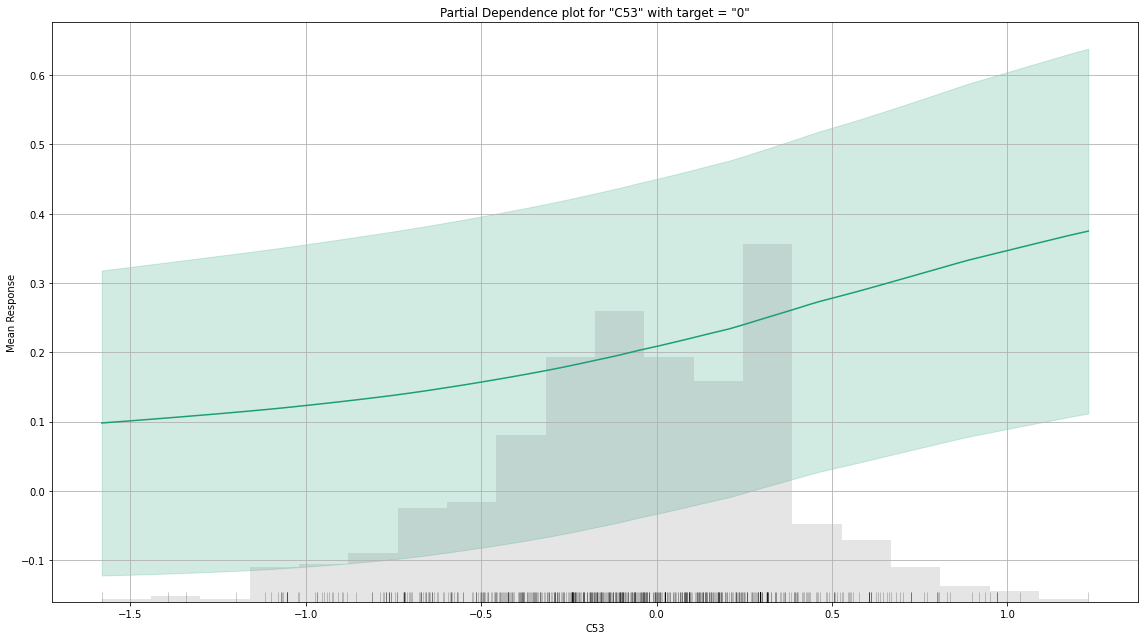

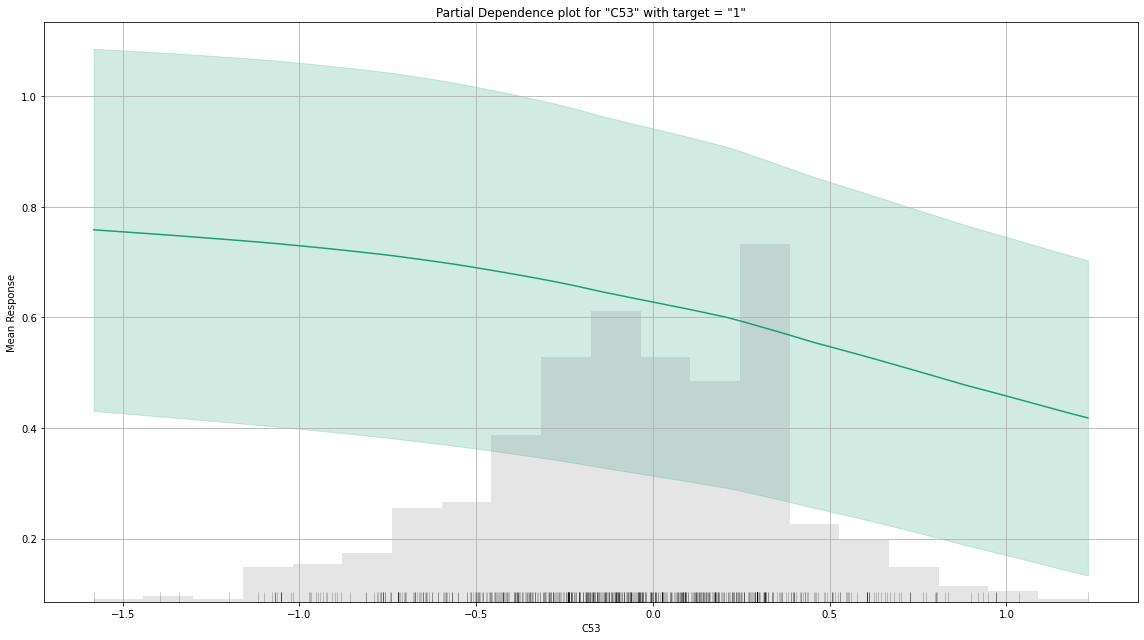

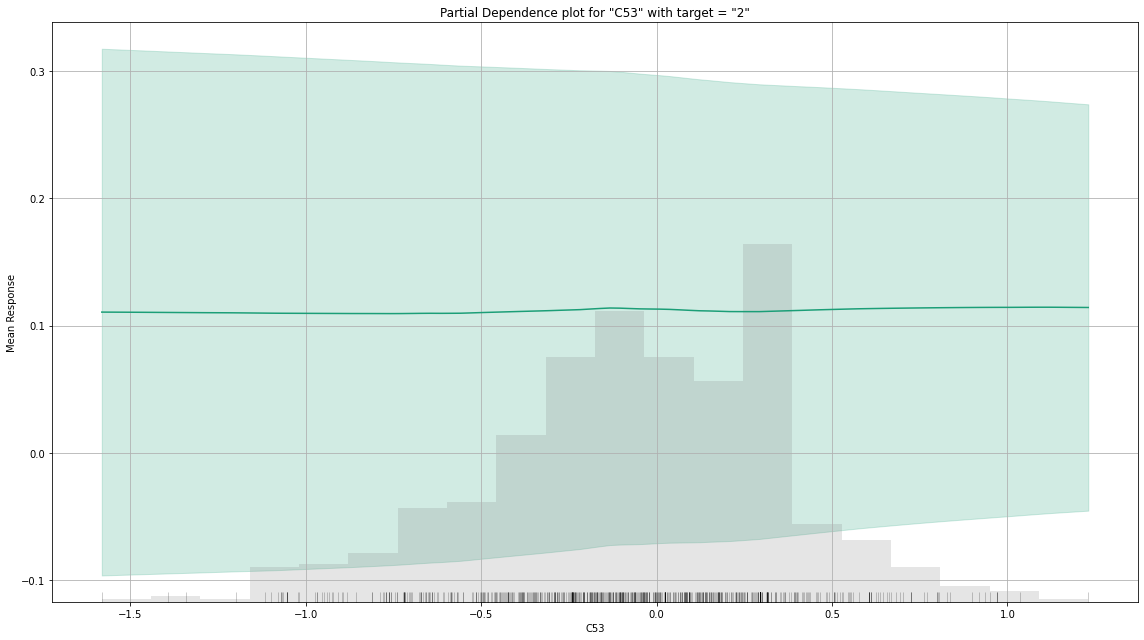

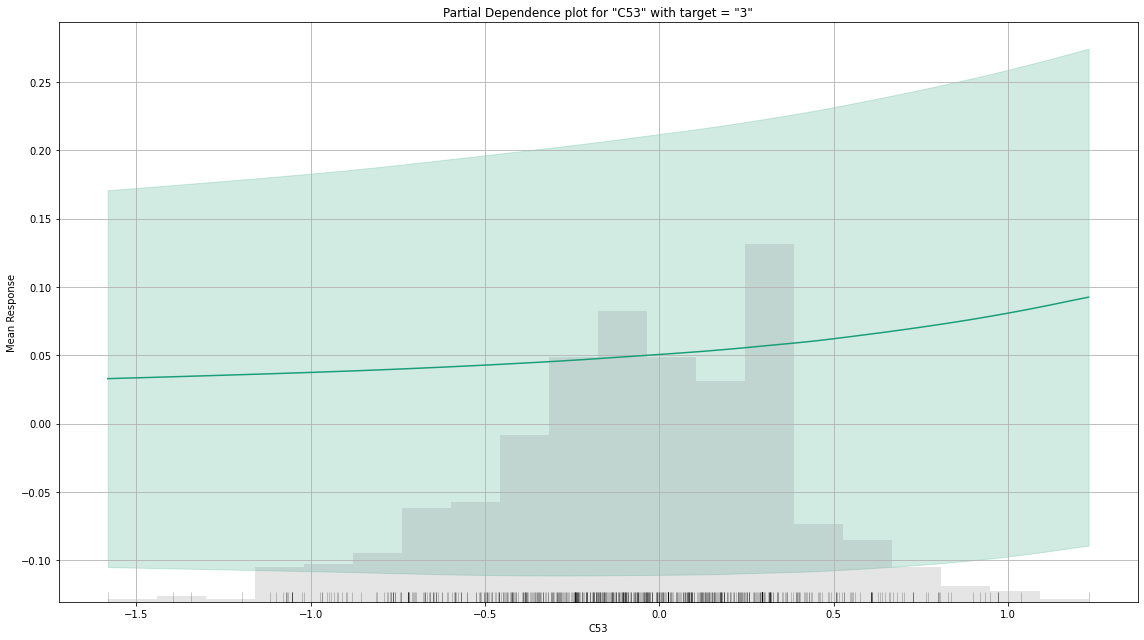

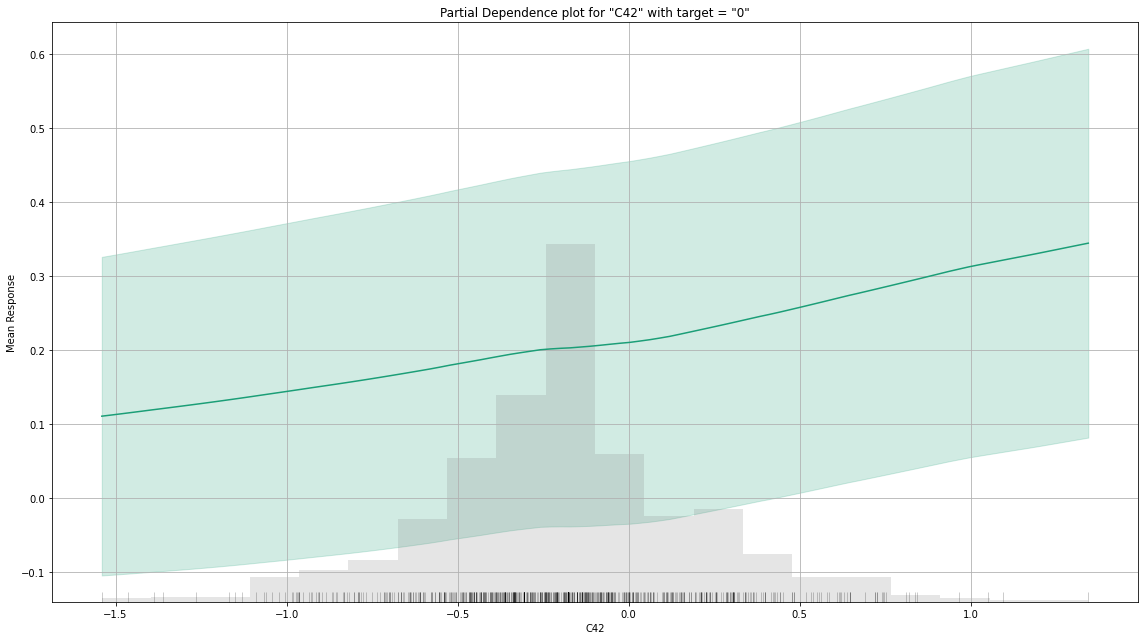

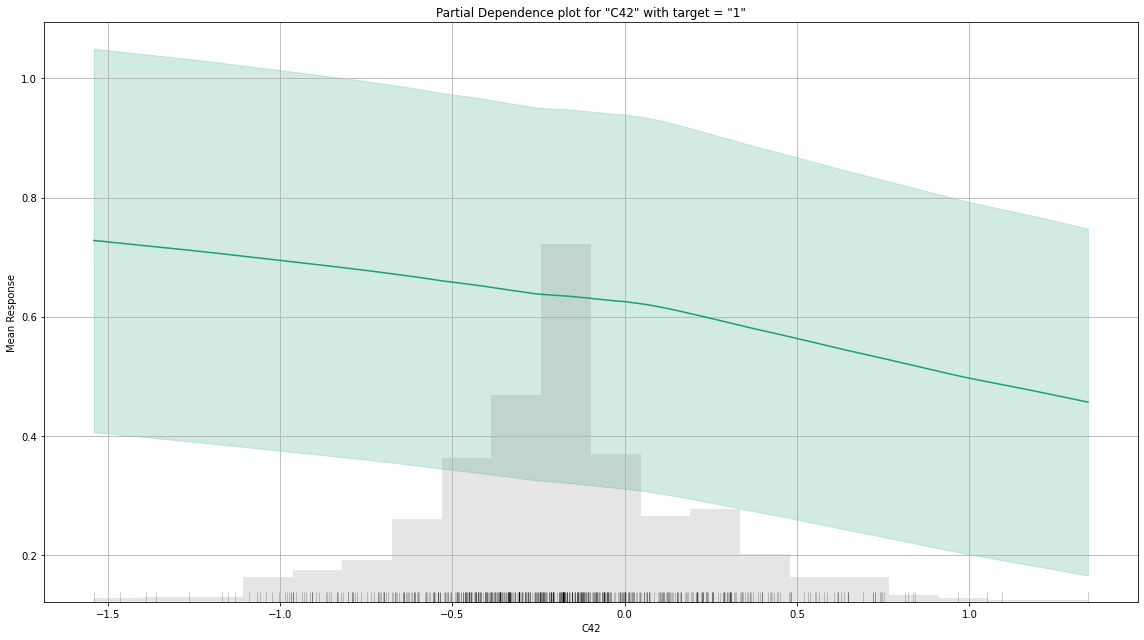

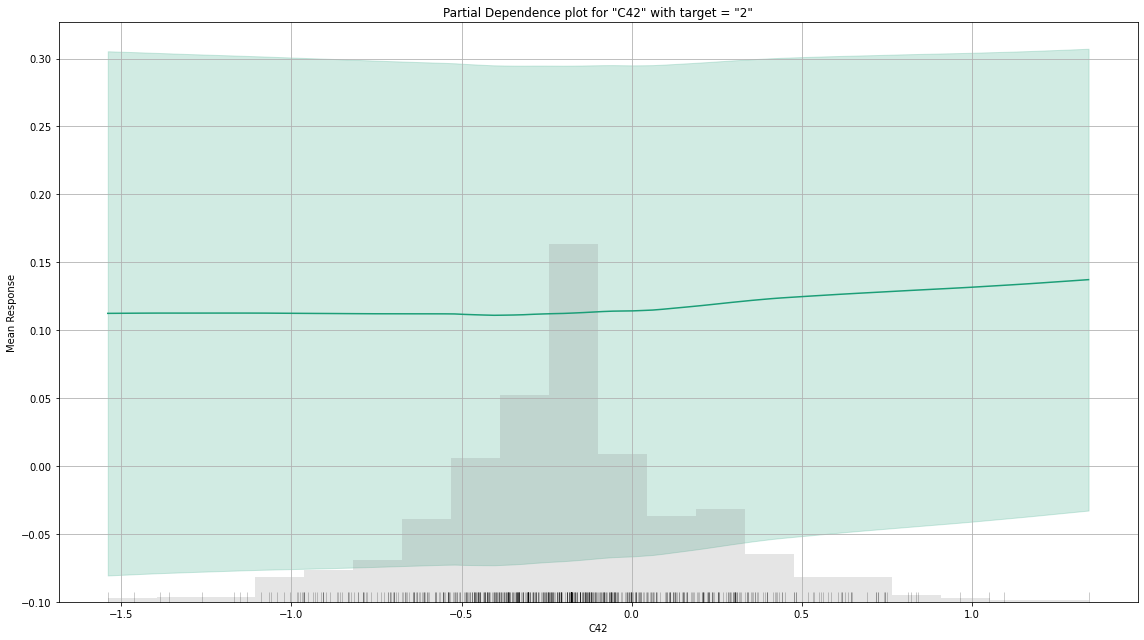

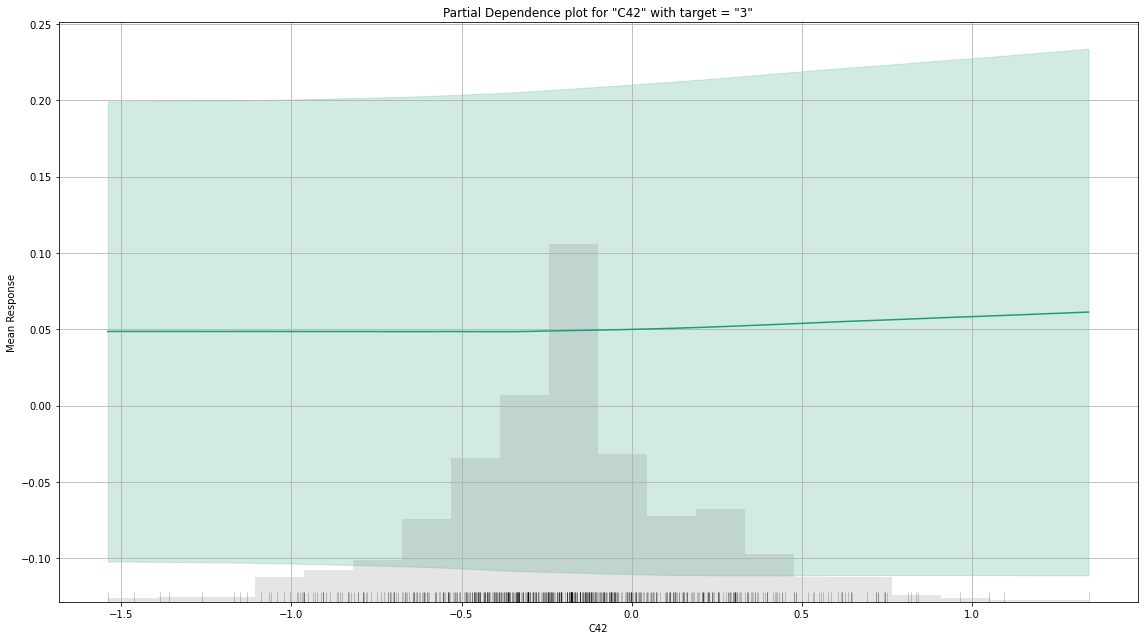

In [27]:
# Retrieve the model's test performance
perf2 = best_dl_model.model_performance(testdata)
perf2

# Explain a model
exm = best_dl_model.explain(testdata)

# Fine Tuning

Model 2 tested on GBM, with Epoch 10

In [15]:
# #### Fine Tuning: Model 2 ####
# w2v_model2 = H2OWord2vecEstimator(epochs = 10, pre_trained = w2v_frame)
# w2v_model2.train(training_frame=words)

# #### Fine Tuning: Model 3 ####
# w2v_model3 = H2OWord2vecEstimator(sent_sample_rate=0.005, pre_trained = w2v_frame)
# w2v_model3.train(training_frame=words)

# #### Fine Tuning: Model 4 ####
# w2v_model4 = H2OWord2vecEstimator(init_learning_rate=0.045, pre_trained = w2v_frame)
# w2v_model4.train(training_frame=words)

# #### Fine Tuning: Model 5 ####
# w2v_model5 = H2OWord2vecEstimator(epochs = 10, sent_sample_rate=0.005, init_learning_rate=0.045, pre_trained = w2v_frame)
# w2v_model5.train(training_frame=words)


In [16]:
# # Calculate a vector for each tweet:
# twitter_tweet_vecs = w2v_model2.transform(words, aggregate_method = "AVERAGE")
# twitter_tweet_test_vecs = w2v_model2.transform(test_words, aggregate_method = "AVERAGE")

# # Prepare training & validation data (keep only tweets made of known words):
# valid_tweet_tweets = ~ twitter_tweet_vecs["C1"].isna()
# data = h2o_train_df[valid_tweet_tweets,:].cbind(twitter_tweet_vecs[valid_tweet_tweets,:])
# data_split = data.split_frame(ratios=[0.8])

# # Prepare test data (keep only tweets made of known words):
# valid_test_tweet_tweets = ~ twitter_tweet_test_vecs["C1"].isna()
# testdata = h2o_test_df[valid_test_tweet_tweets,:].cbind(twitter_tweet_test_vecs[valid_test_tweet_tweets,:])

# # Build a basic GBM model:
# gbm_model2 = H2OGradientBoostingEstimator()
# gbm_model2.train(x = twitter_tweet_vecs.names,
#                 y="label", seed = 1,
#                 training_frame = data_split[0],
#                 validation_frame = data_split[1])

In [17]:
# # Eval performance:
# perf3 = gbm_model2.model_performance(testdata)
# perf3

Model 3 tested on GBM with sent sample rate 0.005

In [18]:
# # Calculate a vector for each tweet:
# twitter_tweet_vecs = w2v_model3.transform(words, aggregate_method = "AVERAGE")
# twitter_tweet_test_vecs = w2v_model3.transform(test_words, aggregate_method = "AVERAGE")

# # Prepare training & validation data (keep only tweets made of known words):
# valid_tweet_tweets = ~ twitter_tweet_vecs["C1"].isna()
# data = h2o_train_df[valid_tweet_tweets,:].cbind(twitter_tweet_vecs[valid_tweet_tweets,:])
# data_split = data.split_frame(ratios=[0.8])

# # Prepare test data (keep only tweets made of known words):
# valid_test_tweet_tweets = ~ twitter_tweet_test_vecs["C1"].isna()
# testdata = h2o_test_df[valid_test_tweet_tweets,:].cbind(twitter_tweet_test_vecs[valid_test_tweet_tweets,:])

# # Build a basic GBM model:
# gbm_model3 = H2OGradientBoostingEstimator()
# gbm_model3.train(x = twitter_tweet_vecs.names,
#                 y="label", seed = 1,
#                 training_frame = data_split[0],
#                 validation_frame = data_split[1])

In [19]:
# # Eval performance:
# perf4 = gbm_model3.model_performance(testdata)
# perf4

Model 4 tested on GBM with initial learning rate 0.045

In [20]:
# # Calculate a vector for each tweet:
# twitter_tweet_vecs = w2v_model4.transform(words, aggregate_method = "AVERAGE")
# twitter_tweet_test_vecs = w2v_model4.transform(test_words, aggregate_method = "AVERAGE")

# # Prepare training & validation data (keep only tweets made of known words):
# valid_tweet_tweets = ~ twitter_tweet_vecs["C1"].isna()
# data = h2o_train_df[valid_tweet_tweets,:].cbind(twitter_tweet_vecs[valid_tweet_tweets,:])
# data_split = data.split_frame(ratios=[0.8])

# # Prepare test data (keep only tweets made of known words):
# valid_test_tweet_tweets = ~ twitter_tweet_test_vecs["C1"].isna()
# testdata = h2o_test_df[valid_test_tweet_tweets,:].cbind(twitter_tweet_test_vecs[valid_test_tweet_tweets,:])

# # Build a basic GBM model:
# gbm_model4 = H2OGradientBoostingEstimator()
# gbm_model4.train(x = twitter_tweet_vecs.names,
#                 y="label", seed = 1,
#                 training_frame = data_split[0],
#                 validation_frame = data_split[1])

In [21]:
# # Eval performance:
# perf5 = gbm_model4.model_performance(testdata)
# perf5

Model 5 tested on GBM with epochs = 10, sent sample rate =0.005 & initial learning rate =0.045 

In [22]:
# # Calculate a vector for each tweet:
# twitter_tweet_vecs = w2v_model4.transform(words, aggregate_method = "AVERAGE")
# twitter_tweet_test_vecs = w2v_model4.transform(test_words, aggregate_method = "AVERAGE")

# # Prepare training & validation data (keep only tweets made of known words):
# valid_tweet_tweets = ~ twitter_tweet_vecs["C1"].isna()
# data = h2o_train_df[valid_tweet_tweets,:].cbind(twitter_tweet_vecs[valid_tweet_tweets,:])
# data_split = data.split_frame(ratios=[0.8])

# # Prepare test data (keep only tweets made of known words):
# valid_test_tweet_tweets = ~ twitter_tweet_test_vecs["C1"].isna()
# testdata = h2o_test_df[valid_test_tweet_tweets,:].cbind(twitter_tweet_test_vecs[valid_test_tweet_tweets,:])

# # Build a basic GBM model:
# gbm_model5 = H2OGradientBoostingEstimator()
# gbm_model5.train(x = twitter_tweet_vecs.names,
#                 y="label", seed = 1,
#                 training_frame = data_split[0],
#                 validation_frame = data_split[1])

In [23]:
# # Eval performance:
# perf6 = gbm_model5.model_performance(testdata)
# perf6